# Instantiating Pulses: Obtaining Pulse Instances From Pulse Templates

In the previous examples, we have modelled pulses using the basic members of qupulse's `PulseTemplate` class hierarchy. However, these are only templates (or classes) of pulses and may contain parameters so that they cannot be run directly on hardware (this is also the reason why we always have to provide some parameters during plotting). First, we have to instantiate a concrete pulse in a process we call *instantiating*. We achieve this by making use of the `create_program()` method and will need to provide concrete parameter values.

The example should be mostly self-contained and easy to follow, however, if you started here and don't know what pulse templates are and how to create them, maybe it's best to have a look at [Modelling a Simple TablePulseTemplate](00SimpleTablePulse.ipynb) first.

To start, let us first create a pulse template with a few parameters and two channels.
## Instantiating a TablePulse

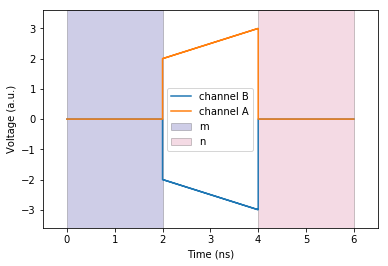

In [1]:
%matplotlib inline
from qupulse.pulses.plotting import plot
from qupulse.pulses import TablePT
template = TablePT(entries={'A': [(0, 0),
                                  ('ta', 'va', 'hold'),
                                  ('tb', 'vb', 'linear'),
                                  ('tend', 0, 'jump')],
                            'B': [(0, 0),
                                  ('ta', '-va', 'hold'),
                                  ('tb', '-vb', 'linear'),
                                  ('tend', 0, 'jump')]}, measurements=[('m', 0, 'ta'),
                                                                       ('n', 'tb', 'tend-tb')])

parameters = {'ta': 2,
              'va': 2,
              'tb': 4,
              'vb': 3,
              'tc': 5,
              'td': 11,
              'tend': 6}
_ = plot(template, parameters, sample_rate=100, show=False, plot_measurements={'m', 'n'})


The `HardwareSetup` class represents the actual hardware and interfaces to the devices in qupulse. It is thus responsible for uploading to and executing pulses on the hardware. To do so it currently expects an instantiated pulse which is represented by `Loop` objects. These can be obtained by plugging the desired parameters into the `create_program` method of your `PulseTemplate` object.

In [2]:
program = template.create_program(parameters=parameters,
                                  channel_mapping={'A': 'A', 'B': 'B'})

print(program)
print('Defined on', program[0].waveform.defined_channels)
print(program.get_measurement_windows())

LOOP 1 times:
  ->EXEC <qupulse._program.waveforms.MultiChannelWaveform object at 0x00000000175562B0> 1 times
Defined on {'B', 'A'}
{'m': (array([0.]), array([2.])), 'n': (array([4.]), array([2.]))}


The output shows us that a simple `Loop` object was created which just executes a single waveform without repetitions, just as our `PulseTemplate` specifies. In the `Loop` object all parameter references from the template have been resolved and replaced by the values provided in the `parameters` dictionary, so this is our pulse ready to be executed on the hardware.

### Mapping Channels and Measurements During Instantiation

The `channel_mapping` keyword argument allows us to rename channels or to drop them by mapping them to `None`. We can do the same to measurements using the `measurement_mapping` keyword argument.

In [3]:
program = template.create_program(parameters=parameters,
                                  channel_mapping={'A': None, 'B': 'Y'},
                                  measurement_mapping={'m': 'foo', 'n': None})
print(program)
print('Defined on', program[0].waveform.defined_channels)
print(program.get_measurement_windows())

LOOP 1 times:
  ->EXEC <qupulse._program.waveforms.TableWaveform object at 0x0000000017546BE0> 1 times
Defined on {'Y'}
{'foo': (array([0.]), array([2.]))}


## Instantiating Composed Pulses

Let's have a brief look at a slightly more complex pulse. Say we want to repeat our previous pulse a few times and follow it up with a brief sine wave on each channel.

LOOP 1 times:
  ->LOOP 4 times:
      ->EXEC <qupulse._program.waveforms.MultiChannelWaveform object at 0x000000001758BF60> 1 times
  ->EXEC <qupulse._program.waveforms.MultiChannelWaveform object at 0x000000001759B668> 1 times
{'m': (array([ 0.,  6., 12., 18.]), array([2., 2., 2., 2.])), 'n': (array([ 4., 10., 16., 22.]), array([2., 2., 2., 2.]))}


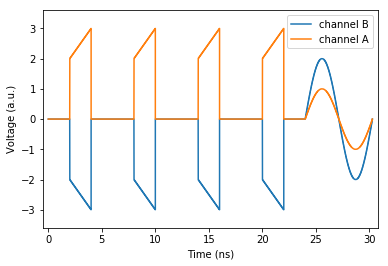

In [4]:
from qupulse.pulses import FunctionPT, SequencePT, RepetitionPT, AtomicMultiChannelPT

repeated_template = RepetitionPT(template, 'n_rep')
sine_template = FunctionPT('sin_a*sin(t)', '2*3.1415')
two_channel_sine_template = AtomicMultiChannelPT(
                                (sine_template, {'default': 'A'}), 
                                (sine_template, {'default': 'B'}, {'sin_a': 'sin_b'})
)
sequence_template = SequencePT(repeated_template, two_channel_sine_template)

sequence_parameters = dict(parameters) # we just copy our parameter dict from before
sequence_parameters['n_rep'] = 4       # and add a few new values for the new params from the sine wave
sequence_parameters['sin_a'] = 1
sequence_parameters['sin_b'] = 2

_ = plot(sequence_template, parameters=sequence_parameters, sample_rate=100, show=False)
sequence_program = sequence_template.create_program(parameters=sequence_parameters, 
                                                    channel_mapping={'A': 'A', 'B': 'B'})
print(sequence_program)
print(sequence_program.get_measurement_windows())

As we can see, our `Loop` now contains an inner `Loop` object which repeats a waveform four times and additionally executes another waveform. This reflects the structure of our pulse template. Note also that the single measurement window defined by our pulse template `template` is repeated four times as well in the `Loop` object, according to the number of repetitions of the corresponding pulse.

Don't worry too much about the inner workings of the `Loop` objects, though. We were just taking a short look at them here. In practice it will be sufficient to just obtain them using the `create_program` method of `PulseTemplate` and pass them on to `HardwareSetup` when required.